# USA air pollution analysis and forcasting using xgboost

In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/mwos/SFI/cryptocurrency-prediction/biqquery.json"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from bq_helper import BigQueryHelper
from google.cloud import bigquery
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Using EPA historical air quality data (USA based)

In [4]:
open_aq = BigQueryHelper(active_project="bigquery-public-data", dataset_name="epa_historical_air_quality")

In [5]:
open_aq.list_tables()

['air_quality_annual_summary',
 'co_daily_summary',
 'co_hourly_summary',
 'hap_daily_summary',
 'hap_hourly_summary',
 'lead_daily_summary',
 'no2_daily_summary',
 'no2_hourly_summary',
 'nonoxnoy_daily_summary',
 'nonoxnoy_hourly_summary',
 'o3_daily_summary',
 'o3_hourly_summary',
 'pm10_daily_summary',
 'pm10_hourly_summary',
 'pm25_frm_daily_summary',
 'pm25_frm_hourly_summary',
 'pm25_nonfrm_daily_summary',
 'pm25_nonfrm_hourly_summary',
 'pm25_speciation_daily_summary',
 'pm25_speciation_hourly_summary',
 'pressure_daily_summary',
 'pressure_hourly_summary',
 'rh_and_dp_daily_summary',
 'rh_and_dp_hourly_summary',
 'so2_daily_summary',
 'so2_hourly_summary',
 'temperature_daily_summary',
 'temperature_hourly_summary',
 'voc_daily_summary',
 'voc_hourly_summary',
 'wind_daily_summary',
 'wind_hourly_summary']

We will focus on hourly data. Starting from the most granual data.

#### Overview of data in table

In [6]:
open_aq.head("co_hourly_summary")

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,date_local,...,units_of_measure,mdl,uncertainty,qualifier,method_type,method_code,method_name,state_name,county_name,date_of_last_change
0,06,077,1002,42101,1,37.950741,-121.268523,NAD83,Carbon monoxide,1993-04-16,...,Parts per million,0.5,None,None,Non-FRM,11,INSTRUMENTAL - NONDISPERSIVE INFRARED,California,San Joaquin,None
1,06,077,1002,42101,1,37.950741,-121.268523,NAD83,Carbon monoxide,1993-04-17,...,Parts per million,0.5,None,None,Non-FRM,11,INSTRUMENTAL - NONDISPERSIVE INFRARED,California,San Joaquin,None
2,06,077,1002,42101,1,37.950741,-121.268523,NAD83,Carbon monoxide,1993-04-18,...,Parts per million,0.5,None,None,Non-FRM,11,INSTRUMENTAL - NONDISPERSIVE INFRARED,California,San Joaquin,None
3,06,077,1002,42101,1,37.950741,-121.268523,NAD83,Carbon monoxide,1993-04-19,...,Parts per million,0.5,None,None,Non-FRM,11,INSTRUMENTAL - NONDISPERSIVE INFRARED,California,San Joaquin,None
4,06,077,1002,42101,1,37.950741,-121.268523,NAD83,Carbon monoxide,1993-04-20,...,Parts per million,0.5,None,None,Non-FRM,11,INSTRUMENTAL - NONDISPERSIVE INFRARED,California,San Joaquin,None


In [7]:
open_aq.head("co_hourly_summary").columns.values.tolist() # column names

['state_code',
 'county_code',
 'site_num',
 'parameter_code',
 'poc',
 'latitude',
 'longitude',
 'datum',
 'parameter_name',
 'date_local',
 'time_local',
 'date_gmt',
 'time_gmt',
 'sample_measurement',
 'units_of_measure',
 'mdl',
 'uncertainty',
 'qualifier',
 'method_type',
 'method_code',
 'method_name',
 'state_name',
 'county_name',
 'date_of_last_change']

Sample measurement and AQI indicators are the most valuable columns for us.

#### Avarage quality of air across counties in the USA in 2015

In [8]:
pollutants = ['o3','co','no2','so2','pm25_frm']

base_query = """
    SELECT
        pollutant.county_name AS County, AVG(pollutant.aqi) AS avg_pollutant
    FROM
      `bigquery-public-data.epa_historical_air_quality.pollutant_daily_summary` as pollutant
    WHERE
      pollutant.poc = 1
      AND EXTRACT(YEAR FROM pollutant.date_local) = 2015
    GROUP BY 
      pollutant.county_name
"""

df = None # reset data frame
for pollutant in pollutants : 
    query = base_query.replace("pollutant", pollutant)
    temp = open_aq.query_to_pandas(query).set_index('County')
    df = pd.concat([df, temp], axis=1, join='outer')
    
df=df.apply(lambda x: x.fillna(x.mean()),axis=0)

df.sample(10,random_state=42)

,avg_o3,avg_co,avg_no2,avg_so2,avg_pm25_frm
Kay,39.630996,4.555269,14.998002,8.550685,32.107462
Pointe Coupee,34.227397,4.555269,14.998002,4.287571,32.107462
Sheboygan,43.576142,4.555269,14.998002,4.287571,32.107462
Atlantic,37.824658,4.555269,14.998002,0.586301,30.004505
Monongalia,43.668224,4.555269,14.998002,3.917808,33.434783
Mitchell,38.645393,4.555269,14.998002,4.287571,29.591667
Blount,38.355109,1.957507,14.998002,4.287571,32.508621
Carroll,44.547739,4.555269,14.998002,4.287571,32.107462
Glenn,39.298630,4.555269,14.998002,4.287571,32.107462
Ottawa,36.958621,4.555269,14.998002,4.823864,32.107462


#### Avarage pollution indicators of air across all years in Callifornia

In [9]:
query_callifornia = """
    SELECT 
        EXTRACT(YEAR FROM date_local) as `Year`,
        AVG(aqi) AS avg_pollutant
    FROM 
        `bigquery-public-data.epa_historical_air_quality.pollutant_daily_summary`
    WHERE 
        state_name  = 'California'
        AND poc = 1
    GROUP BY 
        Year
    ORDER BY
        Year
"""
df = None # reset data frame
for pollutant in pollutants : 
    query = query_callifornia.replace("pollutant", pollutant)
    temp = open_aq.query_to_pandas(query).set_index('Year')
    df = pd.concat([df, temp], axis=1, join='outer')

In [10]:
df

,avg_o3,avg_co,avg_no2,avg_so2,avg_pm25_frm
Year,,,,,
1990,51.098111,19.861226,31.316124,6.993801,NaN
1991,52.360418,19.441517,31.224138,6.535375,NaN
1992,51.253948,17.619513,28.737330,5.771909,NaN
1993,48.635782,16.360953,28.399565,4.372030,NaN
1994,49.873171,16.259633,28.819707,4.982055,NaN
1995,49.171494,15.108372,28.385343,6.098308,NaN
1996,50.322621,13.837452,27.440994,6.032032,NaN
1997,46.034072,13.224436,26.516726,5.606212,NaN
1998,48.336109,13.167468,26.900859,6.339536,111.550000


As we can observe on the above chart, air pollution decreases year by year in Callifronia. PM25 data is incomplete for almost all states/cities in USA, that's why we will focus on CO indicator.

### Daily  and Monthly data of CO in Los Angeles

In [11]:
query_co = """
    SELECT
        date_local,
        aqi
    FROM
        `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
        poc = 1 
        AND county_name = 'Los Angeles'
"""
# state_name  = 'California'
co = open_aq.query_to_pandas(query_co)

In [12]:
co.head()

,date_local,aqi
0,1993-01-23,61.0
1,1994-01-04,111.0
2,1993-12-13,47.0
3,1992-12-26,51.0
4,1994-01-27,32.0


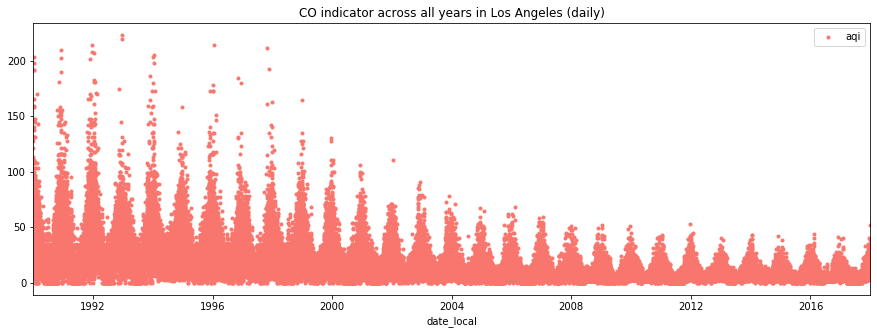

In [13]:
co.set_index('date_local').plot(style='.', figsize=(15,5), color="#F8766D", title='CO indicator across all years in Los Angeles (daily)')

In [14]:
query_co_monthly = """
    SELECT
        FORMAT_DATE("%Y-%m", date_local) as Month,
        AVG(aqi) as avg_aqi
    FROM
        `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
        poc = 1 
        AND county_name = 'Los Angeles'
    GROUP BY 
        Month
    ORDER BY 
        Month ASC
"""
co_monthly = open_aq.query_to_pandas(query_co_monthly)

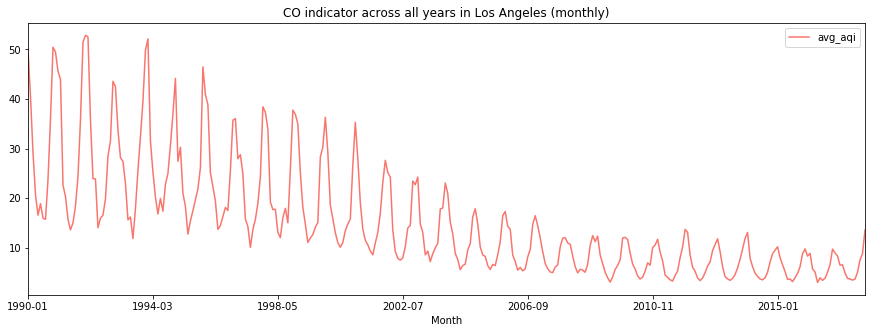

In [15]:
co_monthly.set_index('Month').plot(style='-', figsize=(15,5), color="#F8766D", title='CO indicator across all years in Los Angeles (monthly)')

As we can see - downward trend until 2006. After that CO indicator look stable.  
Also, we can observe a yrealy trend. (those zig-zags). The spiky part probably indicates winter season.

### By day analysis, but using agragate hourly data

In [16]:
query_co_avg_daily = """
    SELECT
        FORMAT_DATE("%Y-%m-%d", date_local) as Day,
        AVG(sample_measurement) as avg_measurement
    FROM
        `bigquery-public-data.epa_historical_air_quality.co_hourly_summary`
    WHERE
        poc = 1 
        AND county_name = 'Los Angeles'
    GROUP BY 
        Day
    ORDER BY 
        Day ASC
"""
co_avg_daily = open_aq.query_to_pandas(query_co_avg_daily)

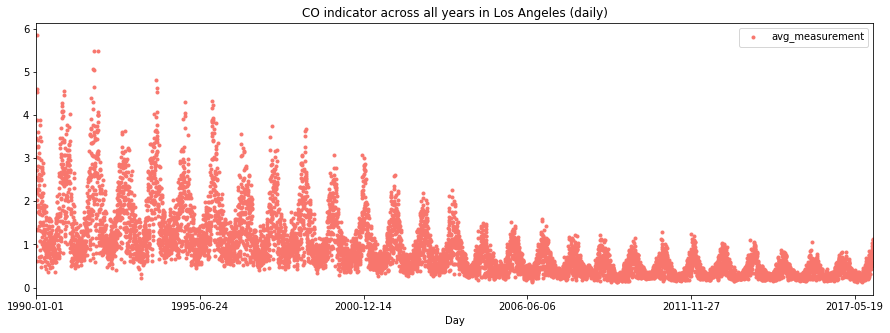

In [17]:
co_avg_daily.set_index('Day').plot(style='.', figsize=(15,5), color="#F8766D", title='CO indicator across all years in Los Angeles (daily)')

### Training, data cleaning, splitting

In [18]:
split_date = '2011-01-01'
co_train = co_avg_daily.loc[co_avg_daily['Day'] <= split_date].copy()
co_test = co_avg_daily.loc[co_avg_daily['Day'] > split_date].copy()

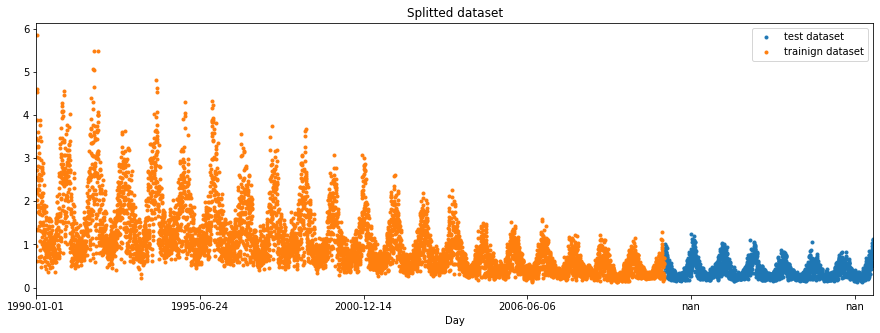

In [19]:
co_test \
    .rename(columns={'avg_measurement': 'test dataset'}) \
    .join(co_train.rename(columns={'avg_measurement': 'trainign dataset'}), how='outer', lsuffix='_left') \
    .set_index('Day') \
    .plot(figsize=(15,5), title='Splitted dataset', style='.')

In [20]:
def create_features_dep(df, x_label='Day', y_label='avg_measurement'):
    df[x_label] = pd.to_datetime(df[x_label])
    
    return df[x_label].as_matrix().reshape((-1,1)), df[y_label].as_matrix()

In [21]:
def create_features(df, x_label='Day', y_label='avg_measurement'):
    df['date'] = pd.to_datetime(df[x_label])
    df['hour'] = df['date'].dt.hour
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofyear','quarter','month','year', 'weekofyear', 'dayofmonth']]
    y = df[y_label]

    return X, y


In [22]:
X_train, y_train = create_features(co_train)
X_test, y_test = create_features(co_test)

### Model training (XGBRegressor)

In [23]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True) 

[16:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.848205	validation_1-rmse:0.213465
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.792084	validation_1-rmse:0.2108
[2]	validation_0-rmse:0.742634	validation_1-rmse:0.206968
[3]	validation_0-rmse:0.70001	validation_1-rmse:0.204899
[4]	validation_0-rmse:0.662701	validation_1-rmse:0.202281
[5]	validation_0-rmse:0.630744	validation_1-rmse:0.199591
[6]	validation_0-rmse:0.602565	validation_1-rmse:0.196859
[7]	validation_0-rmse:0.577489	validation_1-rmse:0.195582
[8]	validation_0-rmse:0.555389	validation_1-rmse:0.195502
[9]	validation_0-rmse:0.536867	validation_1-rmse:0.193545
[10]	validation_0-rmse:0.520905	validation_1-rmse:0.191365
[11]	validation_0-rmse:0.507259	validation_1-rmse:0.187467
[12]	validation_0-rmse:0.49508

[135]	validation_0-rmse:0.396871	validation_1-rmse:0.13858
[136]	validation_0-rmse:0.396585	validation_1-rmse:0.13859
[137]	validation_0-rmse:0.396518	validation_1-rmse:0.138543
[138]	validation_0-rmse:0.396266	validation_1-rmse:0.138524
[139]	validation_0-rmse:0.395881	validation_1-rmse:0.138535
Stopping. Best iteration:
[89]	validation_0-rmse:0.404903	validation_1-rmse:0.137567



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

### Importance of certain features
As we predicted before the most valuable feature is `year`, this feature was most commonly used to split trees, `days` and `weekofyear` came in next. 
Quarter has the lowest importance due to the fact that it could be created by different dayofyear splits.
We will prepare analysis using both `year` and `days` features.

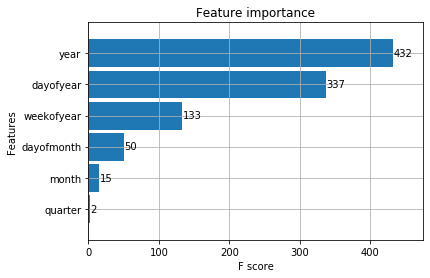

In [24]:
plot_importance(reg, height=0.9)

## Predictions - using DAYS feature

In [25]:
co_test['co_prediction'] = reg.predict(X_test)
co_all = pd.concat([co_test, co_train], sort=True)

In [26]:
co_all.head()

,Day,avg_measurement,co_prediction,date,dayofmonth,dayofyear,hour,month,quarter,weekofyear,year
7671,2011-01-02,0.356426,0.580091,2011-01-02,2,2,0,1,1,52,2011
7672,2011-01-03,0.359434,0.660985,2011-01-03,3,3,0,1,1,1,2011
7673,2011-01-04,0.511438,0.742785,2011-01-04,4,4,0,1,1,1,2011
7674,2011-01-05,0.530284,0.742785,2011-01-05,5,5,0,1,1,1,2011
7675,2011-01-06,0.664423,0.783682,2011-01-06,6,6,0,1,1,1,2011


In [66]:
# Root mean square
((co_test['avg_measurement'] - co_test['co_prediction']).mean() ** 2) ** 0.5

0.03373263760862665

In [27]:
co_all_pred = co_all[['avg_measurement','co_prediction', 'date']] # easier plotting

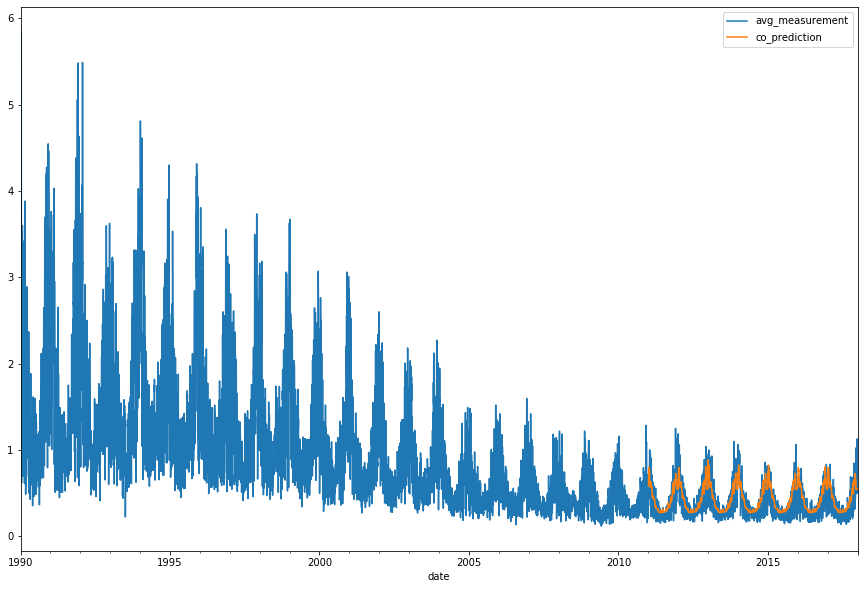

In [28]:
co_all_pred.set_index('date').sort_index().plot(figsize=(15, 10))

Predictions looks fantastic, at least on year by year chart.

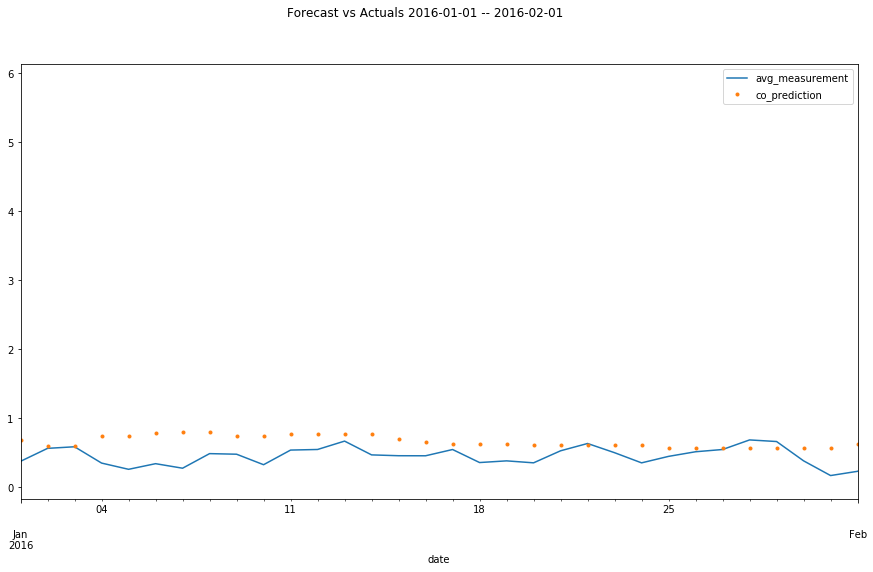

In [29]:
f, ax = plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

co_all_pred.set_index('date').sort_index().plot(ax=ax, style=['-','.'])

ax.set_xbound(lower='2016-01-01', upper='2016-02-01')
plot = plt.suptitle('Forecast vs Actuals 2016-01-01 -- 2016-02-01')

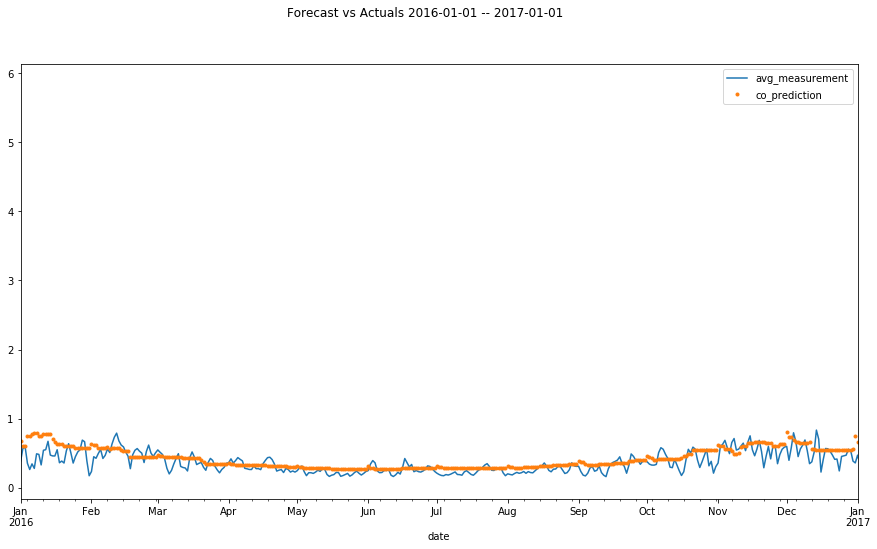

In [30]:
f, ax = plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

co_all_pred.set_index('date').sort_index().plot(ax=ax, style=['-','.'])

ax.set_xbound(lower='2016-01-01', upper='2017-01-01')
plot = plt.suptitle('Forecast vs Actuals 2016-01-01 -- 2017-01-01')

Unfortunatelly, monthly and daaily predictions are not so promising. It would be impossible for any prediction model to fit to such data. The data is very irregular.

#### Worst and best predictions

In [31]:
co_test['error'] = co_test['avg_measurement'] - co_test['co_prediction']
co_test['abs_error'] = co_test['error'].apply(np.abs)

error_by_day = co_test.groupby(['year','month','dayofmonth']).mean()[['avg_measurement','co_prediction','error','abs_error']]

In [32]:
error_by_day.sort_values('abs_error', ascending=False).head(20)

avg_measurement  co_prediction     error  abs_error
year month dayofmonth                                                     
2011 12    31                 1.187975       0.552234  0.635741   0.635741
     11    29                 1.251877       0.627302  0.624575   0.624575
2017 12    26                 1.128794       0.548687  0.580107   0.580107
2011 12    27                 1.095395       0.548687  0.546708   0.546708
           29                 1.093968       0.548687  0.545282   0.545282
2017 12    25                 1.093536       0.548687  0.544849   0.544849
           27                 1.091120       0.548687  0.542433   0.542433
2011 12    30                 1.084026       0.548687  0.535339   0.535339
2016 1     7                  0.278448       0.797956 -0.519507   0.519507
2015 12    9                  1.064794       0.548834  0.515960   0.515960
2017 1     11                 0.256028       0.770585 -0.514556   0.514556
2016 1     5                  0.262500       0.742785 -0.480285   0.480285
2012 12    1                  0.329452       0.807167 -0.477715   0.477715
2011 12    9                  1.124684       0.648188  0.476496   0.476496
2012 12    2                  0.258419       0.729402 -0.470983   0.470983
2017 12    14                 1.025670       0.555791  0.469879   0.469879
2013 11    12                 1.098561       0.633162  0.465399   0.465399
2011 12    1                  0.263987       0.722704 -0.458717   0.458717
2015 11    16                 0.201107       0.652197 -0.451090   0.451090
2017 1     12                 0.320351       0.770585 -0.450234   0.450234

Just from pure curiosity. 
Christmas/New year period generates the most CO.

### Statistical prediction using ETS

According to `Comparing Classical and Machine Learning Algorithms for Time Series Forecasting` (https://machinelearningmastery.com/findings-comparing-classical-and-machine-learning-methods-for-time-series-forecasting/)
statistical methods are superior against ML models. Let's check that theory.

In [33]:
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [34]:
co_test_new = co_test.set_index('Day')
co_train_new = co_train.set_index('Day')

co_test_new = co_test_new['avg_measurement']
co_train_new = co_train_new['avg_measurement']

In [35]:
x_test = pd.to_datetime(co_test['Day'], format="%Y-%m-%d")
x_train = pd.to_datetime(co_train['Day'], format="%Y-%m-%d")

In [36]:
y_hat_avg = co_test_new.copy()
fit1 = ExponentialSmoothing(np.asarray(co_train['avg_measurement']), seasonal_periods=365, trend='add', seasonal='mul').fit()

# fit1 = ExponentialSmoothing(np.asarray(co_train['avg_measurement']) ,seasonal_periods=4 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(co_test_new))

/Users/mwos/.pyenv/versions/3.7.2/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [72]:
# Root mean square
((co_test_new - y_hat_avg['Holt_Winter']).mean() ** 2) ** 0.5

0.18012924764974386

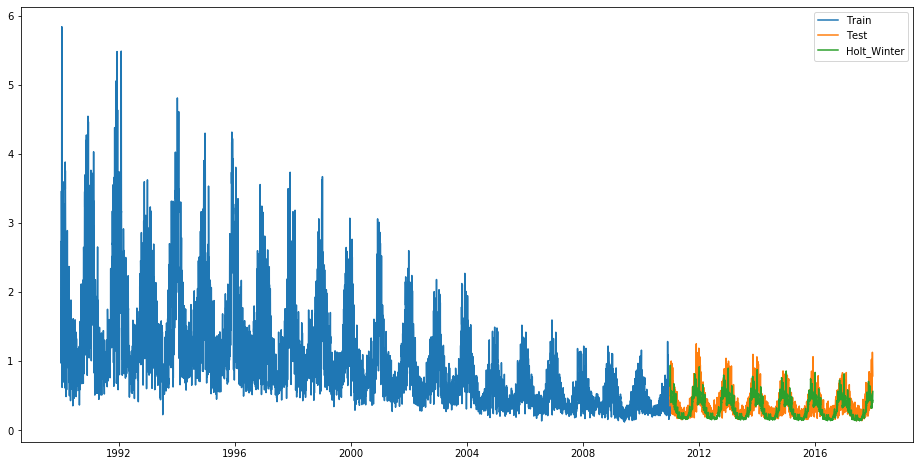

In [37]:
plt.figure(figsize=(16,8))
plt.plot(x_train, co_train_new, label='Train')
plt.plot(x_test, co_test_new, label='Test')
plt.plot(x_test, y_hat_avg['Holt_Winter'], '-', label='Holt_Winter')
plt.legend(loc='best')
plt.show()

## Predictions - using different time window

Now we gonna use data only older than 2000

### Smaller window time - XGBoost

In [38]:
split_date = '2013-01-01'
cut_date = '2000-01-01'

co_train_window = co_avg_daily.loc[co_avg_daily['Day'] <= split_date].copy()
co_test_window = co_avg_daily.loc[co_avg_daily['Day'] > split_date].copy()


co_train_window = co_avg_daily.loc[co_avg_daily['Day'] >= cut_date].copy()

In [39]:
X_train_w, y_train_w = create_features(co_train_window)
X_test_w, y_test_w = create_features(co_test_window)

In [40]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train_w, y_train_w,
        eval_set=[(X_train_w, y_train_w), (X_test_w, y_test_w)],
        early_stopping_rounds=50,
        verbose=True) 

[16:23:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.343702	validation_1-rmse:0.203876
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.325032	validation_1-rmse:0.194542
[2]	validation_0-rmse:0.308546	validation_1-rmse:0.187013
[3]	validation_0-rmse:0.294548	validation_1-rmse:0.180198
[4]	validation_0-rmse:0.282676	validation_1-rmse:0.174334
[5]	validation_0-rmse:0.271575	validation_1-rmse:0.168457
[6]	validation_0-rmse:0.261945	validation_1-rmse:0.163281
[7]	validation_0-rmse:0.253758	validation_1-rmse:0.158526
[8]	validation_0-rmse:0.246889	validation_1-rmse:0.153862
[9]	validation_0-rmse:0.240988	validation_1-rmse:0.150498
[10]	validation_0-rmse:0.235294	validation_1-rmse:0.14728
[11]	validation_0-rmse:0.230843	validation_1-rmse:0.144676
[12]	validation_0-rmse:0.226

[135]	validation_0-rmse:0.181021	validation_1-rmse:0.108107
[136]	validation_0-rmse:0.180938	validation_1-rmse:0.108095
[137]	validation_0-rmse:0.180861	validation_1-rmse:0.108096
[138]	validation_0-rmse:0.180829	validation_1-rmse:0.108058
[139]	validation_0-rmse:0.180777	validation_1-rmse:0.108061
[140]	validation_0-rmse:0.18072	validation_1-rmse:0.107979
[141]	validation_0-rmse:0.18069	validation_1-rmse:0.107955
[142]	validation_0-rmse:0.180624	validation_1-rmse:0.107947
[143]	validation_0-rmse:0.180557	validation_1-rmse:0.107938
[144]	validation_0-rmse:0.180455	validation_1-rmse:0.107822
[145]	validation_0-rmse:0.180341	validation_1-rmse:0.107816
[146]	validation_0-rmse:0.180264	validation_1-rmse:0.107763
[147]	validation_0-rmse:0.180206	validation_1-rmse:0.107779
[148]	validation_0-rmse:0.180158	validation_1-rmse:0.107777
[149]	validation_0-rmse:0.180112	validation_1-rmse:0.107766
[150]	validation_0-rmse:0.180088	validation_1-rmse:0.107749
[151]	validation_0-rmse:0.179996	validatio

[272]	validation_0-rmse:0.173619	validation_1-rmse:0.10448
[273]	validation_0-rmse:0.173537	validation_1-rmse:0.104466
[274]	validation_0-rmse:0.173491	validation_1-rmse:0.104464
[275]	validation_0-rmse:0.173477	validation_1-rmse:0.104464
[276]	validation_0-rmse:0.173465	validation_1-rmse:0.10446
[277]	validation_0-rmse:0.173444	validation_1-rmse:0.104459
[278]	validation_0-rmse:0.173432	validation_1-rmse:0.104454
[279]	validation_0-rmse:0.17339	validation_1-rmse:0.104374
[280]	validation_0-rmse:0.173379	validation_1-rmse:0.104374
[281]	validation_0-rmse:0.173349	validation_1-rmse:0.104355
[282]	validation_0-rmse:0.173232	validation_1-rmse:0.104356
[283]	validation_0-rmse:0.173187	validation_1-rmse:0.104327
[284]	validation_0-rmse:0.173155	validation_1-rmse:0.104248
[285]	validation_0-rmse:0.173117	validation_1-rmse:0.104254
[286]	validation_0-rmse:0.17309	validation_1-rmse:0.104239
[287]	validation_0-rmse:0.173074	validation_1-rmse:0.104164
[288]	validation_0-rmse:0.173039	validation_

[410]	validation_0-rmse:0.16899	validation_1-rmse:0.102006
[411]	validation_0-rmse:0.168966	validation_1-rmse:0.102006
[412]	validation_0-rmse:0.168936	validation_1-rmse:0.101989
[413]	validation_0-rmse:0.168855	validation_1-rmse:0.101973
[414]	validation_0-rmse:0.16882	validation_1-rmse:0.101973
[415]	validation_0-rmse:0.168798	validation_1-rmse:0.101904
[416]	validation_0-rmse:0.168778	validation_1-rmse:0.10192
[417]	validation_0-rmse:0.168714	validation_1-rmse:0.101941
[418]	validation_0-rmse:0.168657	validation_1-rmse:0.101947
[419]	validation_0-rmse:0.168643	validation_1-rmse:0.101935
[420]	validation_0-rmse:0.168639	validation_1-rmse:0.101933
[421]	validation_0-rmse:0.168601	validation_1-rmse:0.101938
[422]	validation_0-rmse:0.168569	validation_1-rmse:0.101918
[423]	validation_0-rmse:0.168549	validation_1-rmse:0.10191
[424]	validation_0-rmse:0.168518	validation_1-rmse:0.101919
[425]	validation_0-rmse:0.168465	validation_1-rmse:0.101918
[426]	validation_0-rmse:0.16844	validation_1

[548]	validation_0-rmse:0.165079	validation_1-rmse:0.100542
[549]	validation_0-rmse:0.165058	validation_1-rmse:0.100529
[550]	validation_0-rmse:0.165049	validation_1-rmse:0.100524
[551]	validation_0-rmse:0.165044	validation_1-rmse:0.100525
[552]	validation_0-rmse:0.165008	validation_1-rmse:0.100515
[553]	validation_0-rmse:0.164968	validation_1-rmse:0.100516
[554]	validation_0-rmse:0.164955	validation_1-rmse:0.100462
[555]	validation_0-rmse:0.164924	validation_1-rmse:0.100458
[556]	validation_0-rmse:0.16491	validation_1-rmse:0.100417
[557]	validation_0-rmse:0.164893	validation_1-rmse:0.100384
[558]	validation_0-rmse:0.164863	validation_1-rmse:0.100386
[559]	validation_0-rmse:0.164824	validation_1-rmse:0.100384
[560]	validation_0-rmse:0.164801	validation_1-rmse:0.100384
[561]	validation_0-rmse:0.164784	validation_1-rmse:0.100386
[562]	validation_0-rmse:0.164703	validation_1-rmse:0.100371
[563]	validation_0-rmse:0.164693	validation_1-rmse:0.100365
[564]	validation_0-rmse:0.164646	validati

[685]	validation_0-rmse:0.161534	validation_1-rmse:0.09935
[686]	validation_0-rmse:0.161442	validation_1-rmse:0.099349
[687]	validation_0-rmse:0.161414	validation_1-rmse:0.099349
[688]	validation_0-rmse:0.161368	validation_1-rmse:0.099351
[689]	validation_0-rmse:0.161353	validation_1-rmse:0.099348
[690]	validation_0-rmse:0.161341	validation_1-rmse:0.099348
[691]	validation_0-rmse:0.161323	validation_1-rmse:0.099349
[692]	validation_0-rmse:0.161307	validation_1-rmse:0.099271
[693]	validation_0-rmse:0.161269	validation_1-rmse:0.099052
[694]	validation_0-rmse:0.161241	validation_1-rmse:0.099039
[695]	validation_0-rmse:0.161223	validation_1-rmse:0.099037
[696]	validation_0-rmse:0.161213	validation_1-rmse:0.099035
[697]	validation_0-rmse:0.161182	validation_1-rmse:0.099028
[698]	validation_0-rmse:0.161168	validation_1-rmse:0.099027
[699]	validation_0-rmse:0.161146	validation_1-rmse:0.099024
[700]	validation_0-rmse:0.161135	validation_1-rmse:0.099009
[701]	validation_0-rmse:0.161107	validati

[822]	validation_0-rmse:0.158683	validation_1-rmse:0.09761
[823]	validation_0-rmse:0.158661	validation_1-rmse:0.097608
[824]	validation_0-rmse:0.158657	validation_1-rmse:0.0976
[825]	validation_0-rmse:0.15863	validation_1-rmse:0.097599
[826]	validation_0-rmse:0.158615	validation_1-rmse:0.097596
[827]	validation_0-rmse:0.158606	validation_1-rmse:0.09757
[828]	validation_0-rmse:0.158593	validation_1-rmse:0.09757
[829]	validation_0-rmse:0.158576	validation_1-rmse:0.097571
[830]	validation_0-rmse:0.158554	validation_1-rmse:0.097569
[831]	validation_0-rmse:0.158536	validation_1-rmse:0.097565
[832]	validation_0-rmse:0.158509	validation_1-rmse:0.09756
[833]	validation_0-rmse:0.158503	validation_1-rmse:0.09756
[834]	validation_0-rmse:0.158468	validation_1-rmse:0.097516
[835]	validation_0-rmse:0.158457	validation_1-rmse:0.097484
[836]	validation_0-rmse:0.15843	validation_1-rmse:0.097431
[837]	validation_0-rmse:0.158419	validation_1-rmse:0.097431
[838]	validation_0-rmse:0.158397	validation_1-rms

[960]	validation_0-rmse:0.156261	validation_1-rmse:0.096309
[961]	validation_0-rmse:0.156217	validation_1-rmse:0.096314
[962]	validation_0-rmse:0.156196	validation_1-rmse:0.096325
[963]	validation_0-rmse:0.156181	validation_1-rmse:0.096329
[964]	validation_0-rmse:0.156144	validation_1-rmse:0.096322
[965]	validation_0-rmse:0.156124	validation_1-rmse:0.096273
[966]	validation_0-rmse:0.156109	validation_1-rmse:0.096274
[967]	validation_0-rmse:0.156094	validation_1-rmse:0.096274
[968]	validation_0-rmse:0.156087	validation_1-rmse:0.096256
[969]	validation_0-rmse:0.156076	validation_1-rmse:0.096238
[970]	validation_0-rmse:0.156054	validation_1-rmse:0.096242
[971]	validation_0-rmse:0.15604	validation_1-rmse:0.096167
[972]	validation_0-rmse:0.156019	validation_1-rmse:0.09617
[973]	validation_0-rmse:0.156006	validation_1-rmse:0.09617
[974]	validation_0-rmse:0.156	validation_1-rmse:0.096147
[975]	validation_0-rmse:0.155969	validation_1-rmse:0.09614
[976]	validation_0-rmse:0.155949	validation_1-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

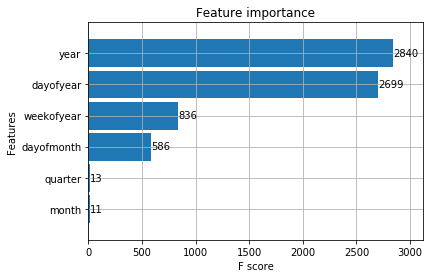

In [41]:
plot_importance(reg, height=0.9)

In [42]:
co_test_window['co_prediction'] = reg.predict(X_test_w)
co_all_w = pd.concat([co_test_window, co_train_window], sort=True)

In [87]:
# Root mean square
((co_test_window['avg_measurement'] - co_test_window['co_prediction']).mean() ** 2) ** 0.5

0.0003907020592585687

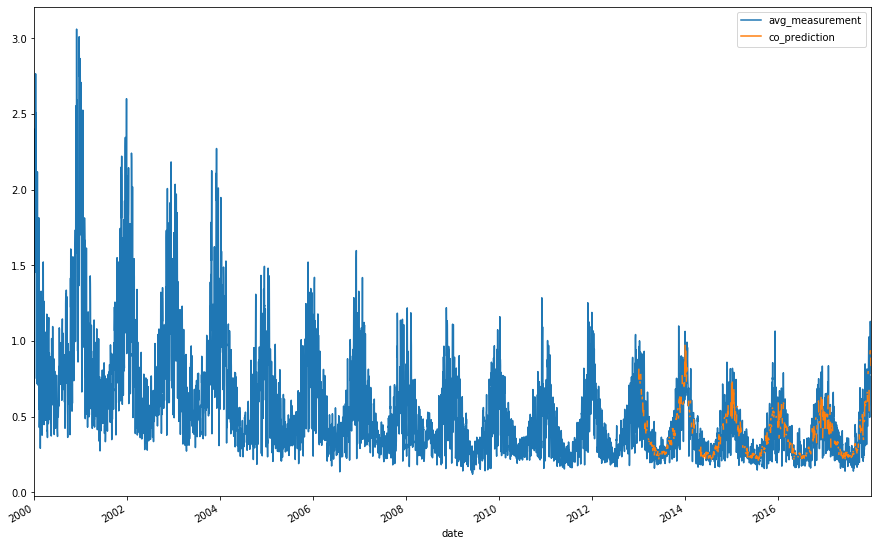

In [43]:
co_all_pred_w = co_all_w[['avg_measurement','co_prediction', 'date']] # easier plotting
co_all_pred_w.set_index('date').sort_index().plot(figsize=(15, 10), style='-')

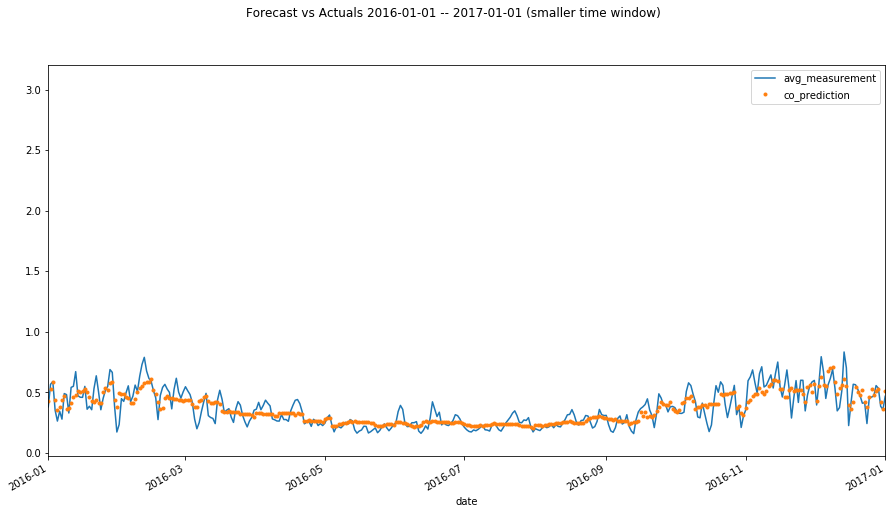

In [44]:
f, ax = plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

co_all_pred_w.set_index('date').sort_index().plot(ax=ax, style=['-','.'])

ax.set_xbound(lower='2016-01-01', upper='2017-01-01')
plot = plt.suptitle('Forecast vs Actuals 2016-01-01 -- 2017-01-01 (smaller time window)')

### Smaller windows time - ETS

In [45]:
co_test_new_win = co_test_window.set_index('Day')
co_train_new_win = co_train_window.set_index('Day')

co_test_new_win = co_test_new_win['avg_measurement']
co_train_new_win = co_train_new_win['avg_measurement']

In [73]:
x_test_win = pd.to_datetime(co_test_window['Day'], format="%Y-%m-%d")
x_train_win = pd.to_datetime(co_train_window['Day'], format="%Y-%m-%d")

In [84]:
y_hat_avg_win = co_test_new_win.copy()
fit1 = ExponentialSmoothing(np.asarray(co_train_window['avg_measurement']), seasonal_periods=365, trend='add', seasonal='mul').fit()
y_hat_avg_win['Holt_Winter'] = fit1.forecast(len(co_test_new_win))

/Users/mwos/.pyenv/versions/3.7.2/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [86]:
# Root mean square
((co_test_new_win - y_hat_avg_win['Holt_Winter']).mean() ** 2) ** 0.5

0.16282600515650078

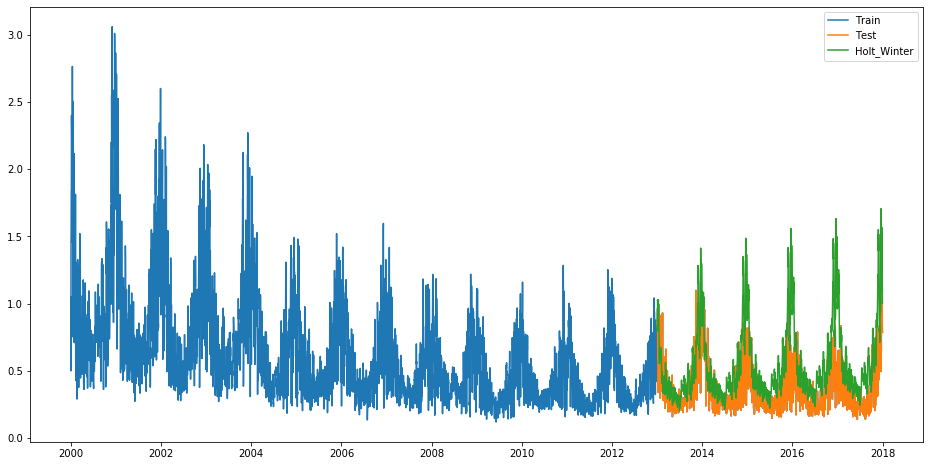

In [85]:
plt.figure(figsize=(16,8))
plt.plot(x_train_win, co_train_new_win, label='Train')
plt.plot(x_test_win, co_test_new_win, label='Test')
plt.plot(x_test_win, y_hat_avg_win['Holt_Winter'], '-', label='Holt_Winter')
plt.legend(loc='best')
plt.show()